In [1]:
# 環境の問題：　 libiomp5.dylib というファイルがダブってる。その対応
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

## データのダウンロード

In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## 画像の型確認

In [3]:
import numpy as np

print("X_train:",x_train.shape, "y_train:", y_train.shape)
print("X_test:",x_test.shape, "y_test:", y_test.shape)

X_train: (50000, 32, 32, 3) y_train: (50000, 1)
X_test: (10000, 32, 32, 3) y_test: (10000, 1)


## 画像の描画

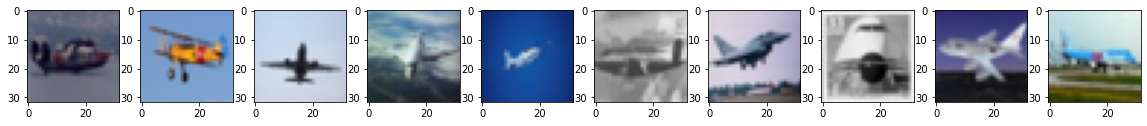

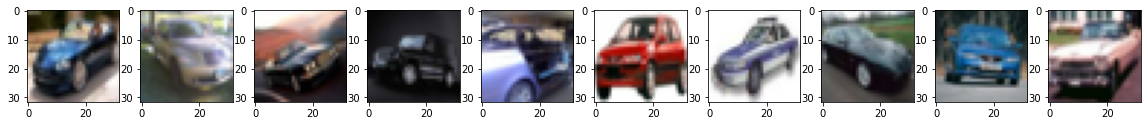

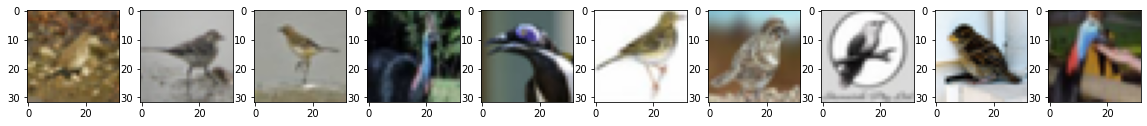

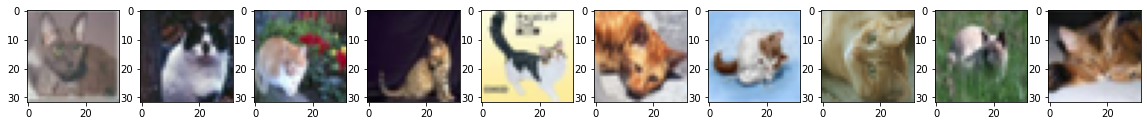

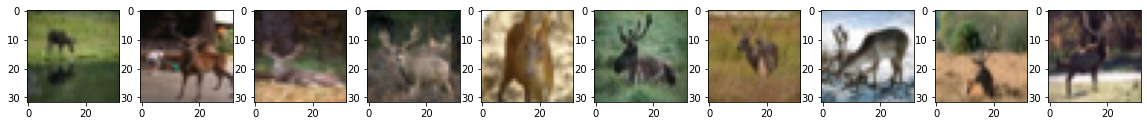

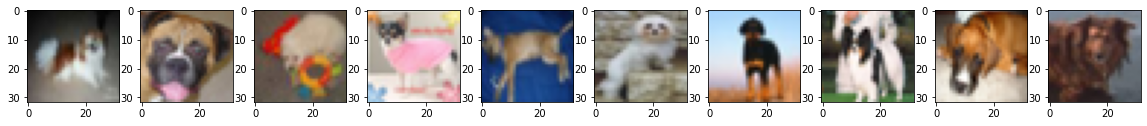

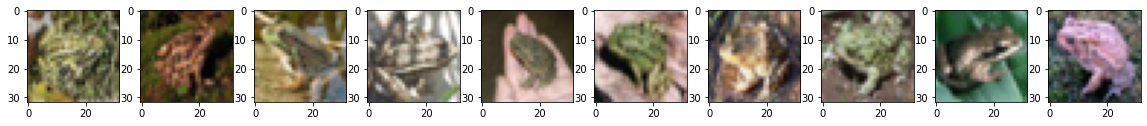

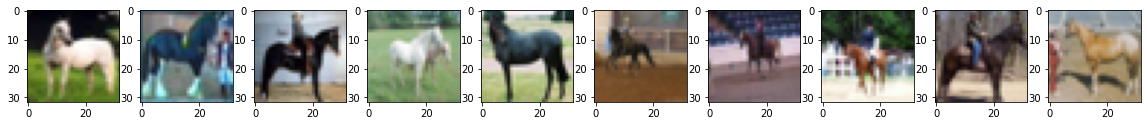

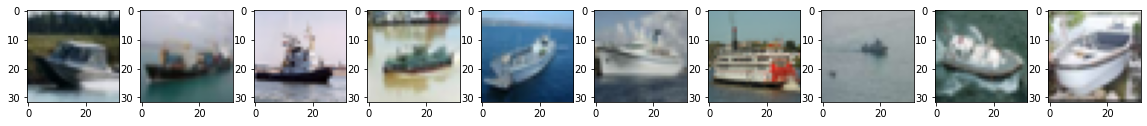

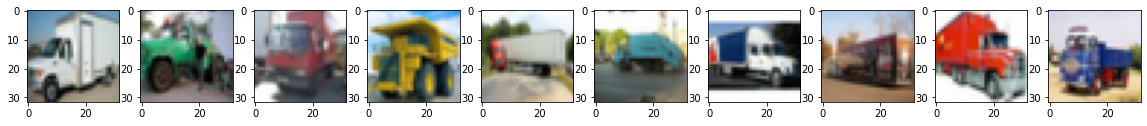

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

num_classes = 10
pos = 1

for target_class in range(num_classes):
    target_idx = [] # 各クラスに分類される画像のインデックスを保持するリスト
    
    # クラスiが正解の場合の正解ラベルのインデックスを表示する
    for i in range(len(y_train)):
        if y_train[i][0] == target_class:
            target_idx.append(i)
            
    np.random.shuffle(target_idx) # クラスiの画像のインデックスをシャッフル
    plt.figure(figsize=(20,20)) # 描画エリアを横20cm, 縦20cmにする
    
    # シャッフルした最初の10枚の画像を描画
    for idx in target_idx[:10]:
        plt.subplot(10, 10, pos) # 10行、10列の描画領域のpos番目の位置を指定
        plt.imshow(x_train[idx])
        pos += 1
        
plt.show()

## 前処理

In [5]:
from tensorflow.keras.utils import to_categorical
x_train = x_train.astype("float32")
x_train /= 255.0
x_test = x_test.astype("float32")
x_test /= 255.0

y_train, y_test = to_categorical(y_train), to_categorical(y_test)

print(x_train, x_test, y_train, y_test)

[[[[0.23137255 0.24313726 0.24705882]
   [0.16862746 0.18039216 0.1764706 ]
   [0.19607843 0.1882353  0.16862746]
   ...
   [0.61960787 0.5176471  0.42352942]
   [0.59607846 0.49019608 0.4       ]
   [0.5803922  0.4862745  0.40392157]]

  [[0.0627451  0.07843138 0.07843138]
   [0.         0.         0.        ]
   [0.07058824 0.03137255 0.        ]
   ...
   [0.48235294 0.34509805 0.21568628]
   [0.46666667 0.3254902  0.19607843]
   [0.47843137 0.34117648 0.22352941]]

  [[0.09803922 0.09411765 0.08235294]
   [0.0627451  0.02745098 0.        ]
   [0.19215687 0.10588235 0.03137255]
   ...
   [0.4627451  0.32941177 0.19607843]
   [0.47058824 0.32941177 0.19607843]
   [0.42745098 0.28627452 0.16470589]]

  ...

  [[0.8156863  0.6666667  0.3764706 ]
   [0.7882353  0.6        0.13333334]
   [0.7764706  0.6313726  0.10196079]
   ...
   [0.627451   0.52156866 0.27450982]
   [0.21960784 0.12156863 0.02745098]
   [0.20784314 0.13333334 0.07843138]]

  [[0.7058824  0.54509807 0.3764706 ]
   [0.6

## モデルの構築

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D # convolution layers
from tensorflow.keras import optimizers

model = Sequential()
# 層1
model.add(
        Conv2D(filters=32,
                       kernel_size=(3,3),
                      padding="same",
                      input_shape=x_train[0].shape,
                      activation="relu"
                      ))
# 層2
model.add(
        Conv2D(filters=32,
                       kernel_size=(3,3),
                      padding="same",
                      activation="relu"
                      ))
# プーリング層
model.add(
        MaxPooling2D(pool_size=(2,2)))
# ドロップアウト
model.add(Dropout(0.5))
# 層4
model.add(
        Conv2D(filters=64,
                       kernel_size=(3,3),
                      padding="same",
                      activation="relu"
                      ))
# 層5
model.add(
        Conv2D(filters=64,
                       kernel_size=(3,3),
                      padding="same",
                      activation="relu"
                      ))
# プーリング層
model.add(
        MaxPooling2D(pool_size=(2,2)))
# ドロップアウト
model.add(Dropout(0.5))
# Flatten
model.add(Flatten())
# 全結合層
model.add(Dense(512,
                               activation="relu"
                               ))
# ドロップアウト
model.add(Dropout(0.5))
# 出力層
model.add(Dense(10,
                              activation="softmax"))
# compile
model.compile(
        loss="categorical_crossentropy", 
        optimizer=optimizers.Adam(lr=0.001), # Adamを使用
        metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

## 学習率を自動で減衰させる仕組みを導入する。
## 指定したepoch数以内に学習の進捗が見られない場合に、学習率を減衰させる。
## 学習が停滞した場合に、学習率の引き下げは有効なので、早期終了の時よりも良い結果が期待できる。

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
        monitor="val__accuracy", # 監視対象は検証データの精度
        factor=0.5, # 学習率を減衰させる割合
        patience=5, # 監視対象のエポック数
        verbose=1, # 学習率を下げたときに通知する
        mode="max", # 最高値を監視する
        min_lr=0.0001 # 学習率の下限
        )
callbacks_list = [reduce_lr]

## データの拡張

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        width_shift_range=0.1, # 横サイズの0.1の割合でランダムに水平移動
        height_shift_range=0.1, # 縦サイズの0.1の割合でランダムに垂直移動
        rotation_range=10, # 10度の範囲でランダムに回転させる
        zoom_range=0.1, # ランダムに拡大
        horizontal_flip=True) # 左右反転

## 学習の実行

In [11]:
%%time

training_epochs = 30
batch_size = 64

history = model.fit(
        x_train,
        y_train,
        epochs=training_epochs,
        batch_size=batch_size,
        verbose=1,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks_list
        )

score = model.evaluate(x_test, y_test, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 322s 8ms/sample - loss: 1.6492 - accuracy: 0.3943 - val_loss: 1.2819 - val_accuracy: 0.5389
Epoch 2/30
40000/40000 [==============================] - 328s 8ms/sample - loss: 1.2727 - accuracy: 0.5436 - val_loss: 1.1068 - val_accuracy: 0.6108
Epoch 3/30
40000/40000 [==============================] - 326s 8ms/sample - loss: 1.1347 - accuracy: 0.5968 - val_loss: 1.0039 - val_accuracy: 0.6454
Epoch 4/30
40000/40000 [==============================] - 324s 8ms/sample - loss: 1.0340 - accuracy: 0.6328 - val_loss: 0.9080 - val_accuracy: 0.6865
Epoch 5/30
40000/40000 [==============================] - 6009s 150ms/sample - loss: 0.9777 - accuracy: 0.6509 - val_loss: 0.8727 - val_accuracy: 0.6896
Epoch 6/30
40000/40000 [==============================] - 5987s 150ms/sample - loss: 0.9246 - accuracy: 0.6737 - val_loss: 0.7963 - val_accuracy: 0.7203
Epoch 7/30
40000/40000 [====================

40000/40000 [==============================] - 326s 8ms/sample - loss: 0.6254 - accuracy: 0.7775 - val_loss: 0.6232 - val_accuracy: 0.7838
Epoch 22/30
40000/40000 [==============================] - 327s 8ms/sample - loss: 0.6027 - accuracy: 0.7847 - val_loss: 0.6178 - val_accuracy: 0.7833
Epoch 23/30
40000/40000 [==============================] - 337s 8ms/sample - loss: 0.6035 - accuracy: 0.7854 - val_loss: 0.6510 - val_accuracy: 0.7777
Epoch 24/30
40000/40000 [==============================] - 347s 9ms/sample - loss: 0.5922 - accuracy: 0.7910 - val_loss: 0.6393 - val_accuracy: 0.7812
Epoch 25/30
40000/40000 [==============================] - 340s 8ms/sample - loss: 0.5819 - accuracy: 0.7930 - val_loss: 0.6632 - val_accuracy: 0.7734
Epoch 26/30
40000/40000 [==============================] - 335s 8ms/sample - loss: 0.5792 - accuracy: 0.7937 - val_loss: 0.6247 - val_accuracy: 0.7870
Epoch 27/30
40000/40000 [==============================] - 332s 8ms/sample - loss: 0.5742 - accuracy: 0.79

## 損失と精度の推移をグラフに

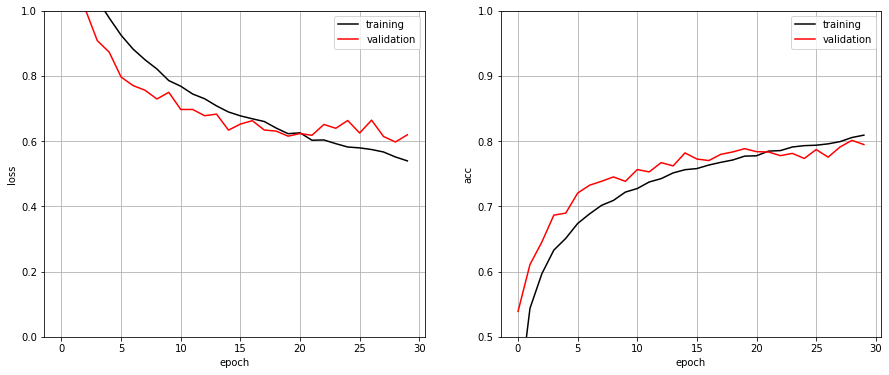

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)

plt.plot(history.history["loss"],
                label="training",
                color="black")

plt.plot(history.history["val_loss"],
                label="validation",
                color="red")
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")


plt.subplot(1,2,2)
plt.plot(history.history["accuracy"],
                label="training",
                color="black")

plt.plot(history.history["val_accuracy"],
                label="validation",
                color="red")
plt.ylim(0.5, 1)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()